# Análisis de sistemas electorales para la Cámara de Diputadas y Diputados de Chile

*Esta es una versión modificada del informe generado con los datos de las
elecciones de 2021. Se quitaron las secciones donde se analizan esos resultados
en particular, pero el resto se mantuvo igual.*

En el presente informe, se utilizan los datos de las elecciones parlamentarias
de Chile de 2025 para simular la distribución de escaños en la Cámara de
Diputadas y Diputados bajo distintos sistemas electorales. Para cada sistema,
se presentan visualizaciones y métricas, como el [índice de
Gallagher](https://en.wikipedia.org/wiki/Gallagher_index) y el [índice de
Loosemore-Hanby](https://en.wikipedia.org/wiki/Loosemore%E2%80%93Hanby_index)
para ver desproporcionalidad, y la [cantidad efectiva de
partidos](https://en.wikipedia.org/wiki/Effective_number_of_parties) para ver
fragmentación.

Se analizan los siguientes sistemas:

- [Proporcional por distrito](#sistemas-proporcionales-por-distrito)
    - [D'Hondt estándar (actualmente usado)](#dhondt-estándar)
    - [D'Hondt con umbral nacional](#dhondt-con-umbral-nacional)
    - [D'Hondt con umbral nacional (con excepciones por cantidad de
      escaños)](#dhondt-con-umbral-nacional-con-excepciones-por-cantidad-de-escaños)
    - [D'Hondt sin pactos](#dhondt-sin-pactos)
- [Proporcional nacional](#sistemas-proporcionales-nacionales)
    - [D'Hondt nacional con umbral bajo](#dhondt-nacional-con-umbral-bajo)
    - [D'Hondt nacional con umbral alto](#dhondt-nacional-con-umbral-alto)
- [Bipartidistas](#sistemas-bipartidistas)
    - [Binominal](#binominal)
    - [Uninominal (first-past-the-post)](#uninominal-first-past-the-post)
- [Sistema biproporcional](#sistema-biproporcional)
- [Mixtos](#sistemas-mixtos)
    - [Mixed-Member Proportional / Additional-Member
      System](#mixed-member-proportional--additional-member-system)
    - [D'Hondt con escaños niveladores](#dhondt-con-escaños-niveladores)
- [Propuesta de *framework*](#propuesta-de-sistema-electoral)

In [1]:
import sys, os
sys.path.append(os.path.abspath(".."))

In [2]:
import pandas as pd

from data_load_utils import *
from systems import *
from apportionment import Apportionment

## Carga de datos

Primero, se carga a un dataframe el archivo `datos_2025.csv` con una
representación ordenada de todas las votaciones obtenidas durante la elección
parlamentaria, exceptuando candidatos independientes fuera de pacto. La
creación de este archivo fue a partir de los resultados oficiales de las
elecciones entregados por el
[Tricel](https://tricel.cl/resultados-de-elecciones/). En el anexo
[`carga_datos_2025.ipynb`](carga_datos_2025.ipynb) se puede ver este proceso
con mayor profundidad.

In [3]:
df = pd.read_csv("datos_2025.csv", index_col=0)

# no se consideran independientes fuera de pacto para este análisis
df = df[df["party"]!="IND"]

Para las simulaciones en las cuales no se utilizan pactos, creamos una copia
del dataframe donde el pacto de cada candidato es reemplazado por su partido.

In [4]:
df_no_pact = df.copy()
df_no_pact["pact"] = df_no_pact["party"]

En las simulaciones usando D'Hondt, se mantendrá la distribución de escaños del
congreso actual para cada uno de los 28 distritos.

In [5]:
district_seats = pd.Series(
    np.array(
        [3, 3, 5, 5, 7, 8, 8, 8, 7, 8, 6, 7, 5, 6,
        5, 4, 7, 4, 5, 8, 5, 4, 7, 5, 4, 5, 3, 3]
    ),
    index=range(1, 29)
)

Para las simulaciones que utilizan distritos binominales y uninominales, se
deben redistribuir los distritos existentes. A cada distrito se le asignó una
cantidad de subdistritos en los cuales dividirse, según su cantidad total de
votantes. La asignación se realizó usando el [método de
Huntington-Hill](https://en.wikipedia.org/wiki/Huntington%E2%80%93Hill_method),
el mismo usado para la asignación de escaños a los distintos estados de los
Estados Unidos en su Cámara de Representantes. Usando este método, se
obtuvieron 40 distritos binominales y 80 distritos uninominales.

Una vez obtenida la cantidad de subdistritos, los candidatos de cada distrito
se reasignaron intentando que cada pacto tuviese una cantidad "equitativa" de
candidatos en cada subdistrito (es decir, si un pacto tenía 9 candidatos en un
distrito que se dividió en 3, se esperarían 3 candidatos del pacto en cada
subdistrito). Esta reasignación no es ideal, pero es útil para un experimento
más exploratorio que riguroso.

In [6]:
# votos totales por distrito
district_votes = df.groupby("district")["votes"].sum()

# escaños iniciales (1 para cada distrito)
initial_seats = pd.Series([1]*28, index=range(1, 29))

huntington_hill_denominator = lambda x: np.sqrt(x * (x + 1))

# asignación de distritos binominales
bin_split = assign_seats_to_parties(
    district_votes,
    40,
    initial_seats,
    huntington_hill_denominator
)
df_bin = redistrict_candidates(df, bin_split)
districts_bin = df_bin["district"].drop_duplicates().to_list()
district_seats_bin = pd.Series([2]*len(districts_bin), index=districts_bin)

# asignación de distritos uninominales
mono_split = assign_seats_to_parties(
    district_votes,
    80,
    initial_seats,
    huntington_hill_denominator
)
df_mono = redistrict_candidates(df, mono_split)
districts_mono = df_mono["district"].drop_duplicates().to_list()
district_seats_mono = pd.Series([1]*len(districts_mono), index=districts_mono)

Finalmente, se utiliza el diccionario `colors` para asignar un color RGB a cada partido político (a usarse en las representaciones visuales de cada simulación), y también para ordenar los partidos según el eje izquierda-derecha en los diagramas de hemiciclo.

In [7]:
colors = pd.Series({
    "PTR": "#BE0411",

    "IGUALDAD": "#000000",
    "PH": "#FF4500",
    "PEV": "#03BF00",
    "POPULAR": "#692C65",
    "PAVP": "#0B5A00",

    "FREVS": "#008000",
    "AH": "#F47F48",
    
    "PCCH": "#B22222",
    "FA": "#20AAE2",
    "PS": "#ED1624",
    "PPD": "#FFA500",
    "PR": "#CD5C5C",
    "PL": "#FFD700",
    "PDC": "#1E90FF",
    
    "IND": "#808080",
    
    "PDG": "#00285E",
    
    "AMARILLOS": "#FFBA14",

    "DEMOCRATAS": "#DA1764",
    "EVOPOLI": "#0CB8E6",
    "RN": "#024E9A",
    "UDI": "#29398A",

    "REPUBLICAN": "#22446D",
    "PSC": "#0096BA",
    "PNL": "#B9935A",
})

party_order = list(colors.keys())

## Sistemas proporcionales por distrito

Los sistemas proporcionales intentan entregar escaños acorde a la cantidad de
gente que votó por cada partido. Cuando son sistemas por distrito, entonces
cada distrito asigna sus escaños de forma independiente, intentando entregar la
mayor proporcionalidad al interior del distrito.

Características de los sistemas proporcionales por distrito:
- Proporcionalidad a nivel de distrito no necesariamente implica una buena
  proporcionalidad a nivel nacional. En general, cualquier método tenderá a
  sobrerrepresentar partidos que tienen un muy buen rendimiento en pocos
  distritos, versus aquellos que tienen un rendimiento parejo a nivel nacional.
  Además, el [método de
  D'Hondt/Jefferson](https://en.wikipedia.org/wiki/D%27Hondt_method), usado en
  Chile y analizado en esta sección, tiende a favorecer a partidos más grandes
  por sobre los más pequeños.
- Existe un trade-off en el tamaño de los distritos: aumentar la cantidad de
  escaños por distrito aumenta la proporcionalidad a nivel distrital y
  nacional; por otra parte, implica papeletas más grandes y difíciles de
  contar, y un aumento en el tamaño del Congreso o en las áreas que cubren cada
  uno de los distritos (esto último se traduce a una menor "conexión" entre
  diputados y votantes).
- Propenso al "arrastre", donde candidatos con muy pocos votos son electos
  debido a que un compañero de partido/pacto consiguió una proporción muy
  grande de los votos. Esto hace mella en la legitimidad del sistema, pues las
  personas ven diputados electos en distritos donde obtuvieron menos del 1% de
  los votos. Cabe destacar que este problema nace a partir de una
  interpretación equivocada del sistema electoral por parte de los votantes:
  piensan que votan únicamente por un **candidato**, cuando en verdad también
  están votando por su **partido** (y su pacto). La existencia del arrastre
  permite una mayor proporcionalidad en cuanto a partidos, pues de lo contrario
  la mayoría los votos hacia un candidato muy popular se perderían (al no ser
  entregados a otros candidatos del partido).

### D'Hondt estándar

El sistema de D'Hondt con pactos, y sin ningún tipo de umbral electoral, es
usado en Chile para elecciones parlamentarias desde el año 2017. Cada uno de
los 28 distritos escogen a 3-8 diputados de manera proporcional. Un sistema
similar se usa para el [Congreso de los Diputados de
España](https://en.wikipedia.org/wiki/Elections_in_Spain#Congress_of_Deputies)
y en la [Cámara de Diputados de
Argentina](https://en.wikipedia.org/wiki/Argentine_Chamber_of_Deputies), solo
que con listas cerradas y con algunos distritos mucho más grandes (en teoría
también hay un umbral electoral por distrito, pero en la práctica no afecta
particularmente).

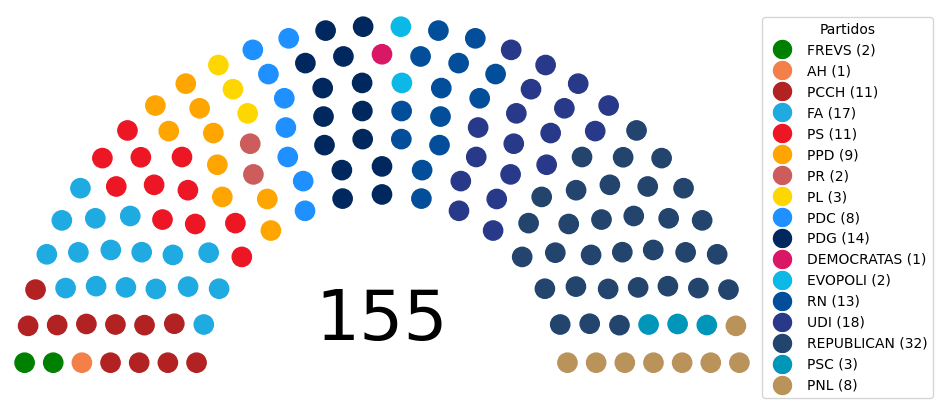

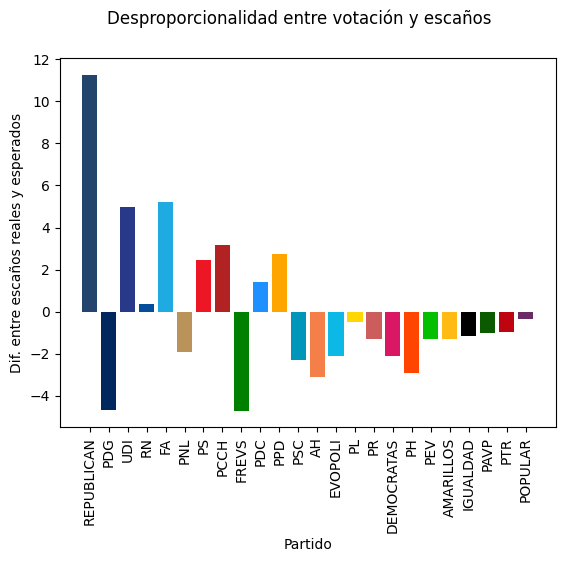

RESUMEN DE ESTADÍSTICAS:
            
Mediana de votación para candidatos electos: 7.50%

Candidatos con menos votos que fueron electos:
                                 Pacto Partido  Distrito  Votos (%)
Candidato                                                          
BERNARDO SALINAS MAYA           UNIDAD    PCCH         5   0.851361
LORENA FRIES MONLEON            UNIDAD      FA        10   0.881533
FERNANDO ZAMORANO PERALTA       UNIDAD     PPD        15   1.339114
ROBERTO ARROYO MUÑOZ       REP/PNL/PSC     PSC        20   1.344376
ZANDRA PARISI FERNANDEZ            PDG     PDG        12   2.464636

Candidatos con más votos que no fueron electos:
                                      Pacto     Partido  Distrito  Votos (%)
Candidato                                                                   
LUPERCIANO MUÑOZ GONZALEZ            UNIDAD          PR        27  12.730015
MARCIA RAPHAEL MORA              CHILEVAMOS          RN        27  10.204867
RAMON GALLEGUILLOS CASTILLO   

In [8]:
results_dhondt = appoint_divisor_district(
    df,
    district_seats=district_seats,
    assign_type="dhondt",
    party_threshold=0.00
)
app_dhondt = Apportionment(
    results=results_dhondt,
    colors=colors,
    party_order=party_order
)

app_dhondt.summary()

### D'Hondt con umbral nacional

Una de las reformas más mencionadas para el sistema político chileno involucra
la creación de un [umbral
electoral](https://www.t13.cl/noticia/politica/udi-presenta-proyecto-para-establecer-5-votos-para-partidos-politicos-16-1-2024)
a nivel nacional, mediante el cual partido que obtengan una votación nacional
menor al umbral no podrán competir por ningún escaño. Sistemas similares se
utilizan en la [Cámara de Diputados de
Brasil](https://en.wikipedia.org/wiki/Chamber_of_Deputies_(Brazil)), el
[Congreso de
Perú](https://en.wikipedia.org/wiki/Congress_of_the_Republic_of_Peru) y el
[Consejo Nacional de
Austria](https://en.wikipedia.org/wiki/National_Council_(Austria)), aunque cabe
mencionar que ninguno permite la creación de pactos entre partidos (como sí
ocurre en Chile).

El umbral más comúnmente propuesto es del 5%, pero en vista del *dataset* con
el cual se trabaja se utilizará un umbral del 4% para permitir que más partidos
accedan a escaños. En la realidad, se esperaría que de promulgarse esta
reforma, los partidos más pequeños se fusionaran para lograr el 5% (como ya
hizo el [Frente
Amplio](https://elpais.com/chile/2024-07-15/el-frente-amplio-la-formacion-de-boric-elige-su-primera-directiva-tras-la-union-de-sus-partidos.html)).

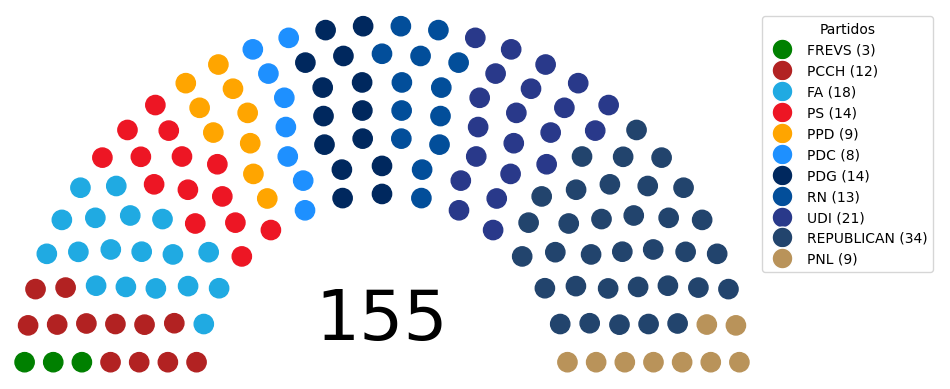

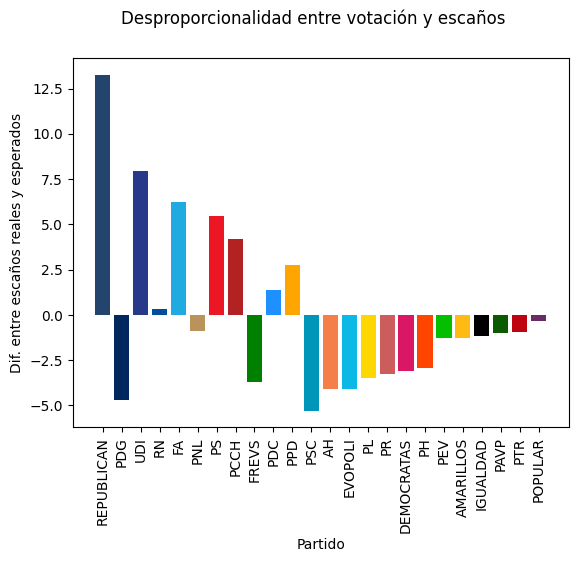

RESUMEN DE ESTADÍSTICAS:
            
Mediana de votación para candidatos electos: 7.20%

Candidatos con menos votos que fueron electos:
                                   Pacto Partido  Distrito  Votos (%)
Candidato                                                            
HERNAN PALMA PEREZ              FREVS/AH   FREVS        12   0.764330
BERNARDO SALINAS MAYA             UNIDAD    PCCH         5   0.851361
LORENA FRIES MONLEON              UNIDAD      FA        10   0.881533
FERNANDO ZAMORANO PERALTA         UNIDAD     PPD        15   1.339114
REINALDO GONZALEZ MARIANGEL  REP/PNL/PSC     PNL        20   2.159996

Candidatos con más votos que no fueron electos:
                                      Pacto Partido  Distrito  Votos (%)
Candidato                                                               
SEBASTIAN PATRICIO VIDELA CASTILLO   UNIDAD      PL         3  23.306486
LUIS MALLA VALENZUELA                UNIDAD      PL         1  21.535515
CONSUELO VELOSO AVILA           

In [9]:
results_dhondt_threshold = appoint_divisor_district(
    df,
    district_seats=district_seats,
    assign_type="dhondt",
    party_threshold=0.04
)
app_dhondt_threshold = Apportionment(
    results=results_dhondt_threshold,
    colors=colors,
    party_order=party_order
)

app_dhondt_threshold.summary()

### D'Hondt con umbral nacional (con excepciones por cantidad de escaños)

Inspirado en D'Hondt con umbral nacional, se propone una modificación que exime
del umbral a aquellos partidos que, sin considerar el umbral, hayan obtenido
una cantidad mínima de escaños. Esta es [una de las reformas que se ha
propuesto](https://www.senado.cl/comunicaciones/noticias/reforma-al-sistema-politico-y-electoral-comision-ratifica-umbral-del-5-para)
en el contexto chileno, considerando un umbral nacional del 5% y exenciones
para aquellos partidos que tengan al menos 8 parlamentarios en el Congreso
(contemplando ambas cámaras).

Para efectos de este experimento, se utilizó un umbral nacional de 4% (al igual
que el experimento anterior), y exenciones para aquellos partidos con al menos
4 diputados electos sin considerar los umbrales.

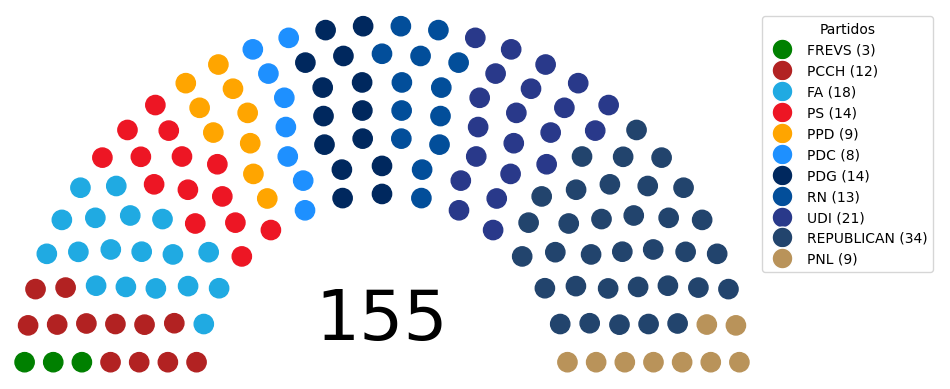

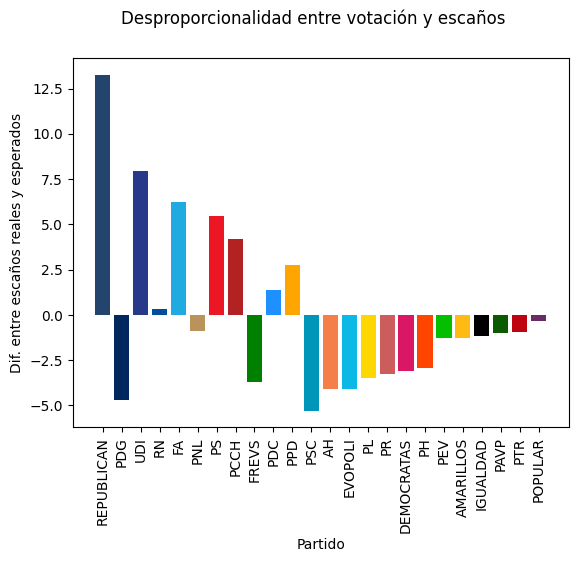

RESUMEN DE ESTADÍSTICAS:
            
Mediana de votación para candidatos electos: 7.20%

Candidatos con menos votos que fueron electos:
                                   Pacto Partido  Distrito  Votos (%)
Candidato                                                            
HERNAN PALMA PEREZ              FREVS/AH   FREVS        12   0.764330
BERNARDO SALINAS MAYA             UNIDAD    PCCH         5   0.851361
LORENA FRIES MONLEON              UNIDAD      FA        10   0.881533
FERNANDO ZAMORANO PERALTA         UNIDAD     PPD        15   1.339114
REINALDO GONZALEZ MARIANGEL  REP/PNL/PSC     PNL        20   2.159996

Candidatos con más votos que no fueron electos:
                                      Pacto Partido  Distrito  Votos (%)
Candidato                                                               
SEBASTIAN PATRICIO VIDELA CASTILLO   UNIDAD      PL         3  23.306486
LUIS MALLA VALENZUELA                UNIDAD      PL         1  21.535515
CONSUELO VELOSO AVILA           

In [10]:
results_dhondt_threshold_two_step = appoint_divisor_district_two_step(
    df,
    district_seats=district_seats,
    assign_type="dhondt",
    party_threshold=0.04,
    minimum_seats=4
)
app_dhondt_threshold_two_step = Apportionment(
    results=results_dhondt_threshold_two_step,
    colors=colors,
    party_order=party_order
)

app_dhondt_threshold_two_step.summary()

### D'Hondt sin pactos

Otra idea que se ha propuesto para el sistema político chileno (aunque sin
particular apoyo parlamentario) consiste en la [eliminación de los pactos entre
partidos](https://www.ciperchile.cl/2024/11/07/reforma-al-sistema-politico-vamos-al-fondo-del-problema/)
para las elecciones. Como se mencionó en [la sección
anterior](#dhondt-con-umbral-nacional), este sistema (con umbrales nacionales)
se utiliza en países como Brasil, Perú y Austria. También se usa con umbrales a
nivel de distrito en la [Cámara de Representantes de
Colombia](https://en.wikipedia.org/wiki/Chamber_of_Representatives_of_Colombia).

**Observación**: en la simulación realizada, se usaron los datos sin pactos,
pero esta información se volvió a agregar tras la simulación para poder
analizar métricas sobre los "pactos" que se formarían *de facto* en el
Congreso. Esto se hará para todas las simulaciones que no utilicen pactos.

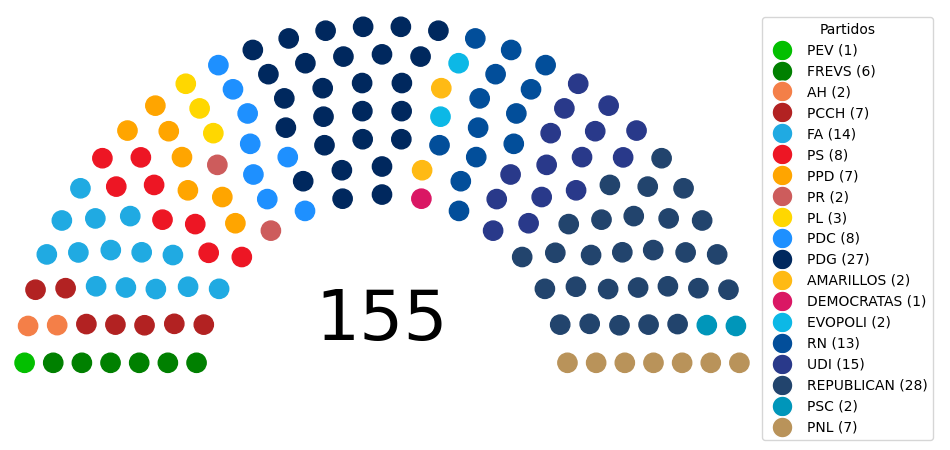

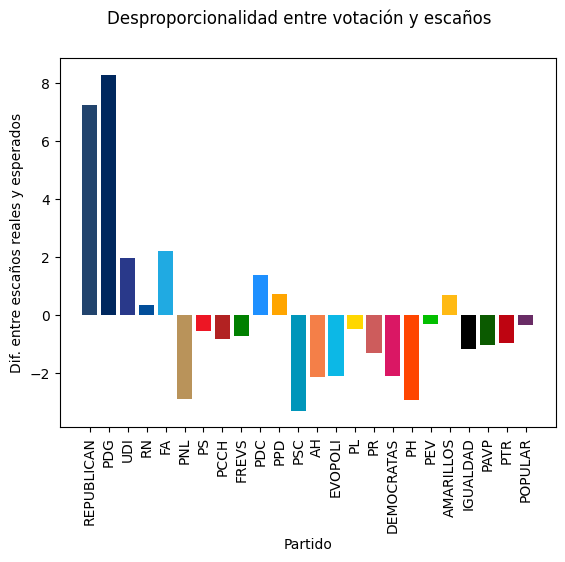

RESUMEN DE ESTADÍSTICAS:
            
Mediana de votación para candidatos electos: 7.42%

Candidatos con menos votos que fueron electos:
                                Pacto Partido  Distrito  Votos (%)
Candidato                                                         
LORENA FRIES MONLEON           UNIDAD      FA        10   0.881533
FERNANDO ZAMORANO PERALTA      UNIDAD     PPD        15   1.339114
SERGIO MARMIE IBARRONDO           PDG     PDG         3   1.448739
LEYLA MASSIEL JARA LOPEZ          PDG     PDG         8   1.448748
CAMILA FRANCESCA DOÑAS VARGAS     PDG     PDG         6   2.177350

Candidatos con más votos que no fueron electos:
                                    Pacto     Partido  Distrito  Votos (%)
Candidato                                                                 
ALEJANDRA VALDEBENITO TORRES   CHILEVAMOS         UDI        27  10.349253
MARCIA RAPHAEL MORA            CHILEVAMOS          RN        27  10.204867
RAMON GALLEGUILLOS CASTILLO    CHILEVAMOS    

In [11]:
results_dhondt_no_pact = appoint_divisor_district(
    df_no_pact,
    district_seats=district_seats,
    assign_type="dhondt",
    party_threshold=0.00
)
results_dhondt_no_pact.loc[:, "pact"] = df["pact"]

app_dhondt_no_pact = Apportionment(
    results=results_dhondt_no_pact,
    colors=colors,
    party_order=party_order
)

app_dhondt_no_pact.summary()

## Sistemas proporcionales nacionales

Los sistemas proporcionales nacionales son muy similares a los sitemas por
distrito, solo que suman todos los votos en un único "distrito nacional". Para
efectos de esta simulación, se realizará la elección de los diputados de cada
partido en base a la cantidad de votos que obtuvieron, y **no se utilizarán
pactos electorales**.

Características de los sistemas proporcionales nacionales:

* Logran una mayor representatividad a nivel nacional que los sistemas
  proporcionales por distrito.
* Como no existe el concepto de distrito, no hay ninguna certeza de que hayan
  representantes de todas las zonas del país en el parlamento. En nuestra
  simulación, esto se verá reflejado en que los distritos más pequeños (como
  Aysén o Magallanes) no tendrán ningún candidato que haya alcanzado los votos
  suficientes como para ser electo, quedándose así sin representación.

### D'Hondt nacional con umbral bajo

La mayoría de países que implementan D'Hondt nacional tienen umbrales
electorales muy pequeños o nulos. Para la [Cámara de Representantes de los
Países
Bajos](https://en.wikipedia.org/wiki/House_of_Representatives_(Netherlands)),
el umbral es equivalente al porcentaje que representa un escaño en el
parlamento (1/150, pues son 150 escaños). En el caso del [Senado de
Uruguay](https://en.wikipedia.org/wiki/Senate_of_Uruguay), no existen umbrales
electorales, aunque debido a la baja cantidad de escaños existe un **umbral
natural** relativamente alto.

Para esta simulación, se decidió usar un umbral electoral como el de los Países
Bajos, aunque en este caso sería 1/155 pues son 155 escaños en la Cámara.
Las diferencias son mínimas si no se usa un umbral, ya que Ciudadanos y el PRI
serían los únicos partidos nuevos que ingresarían al Congreso.

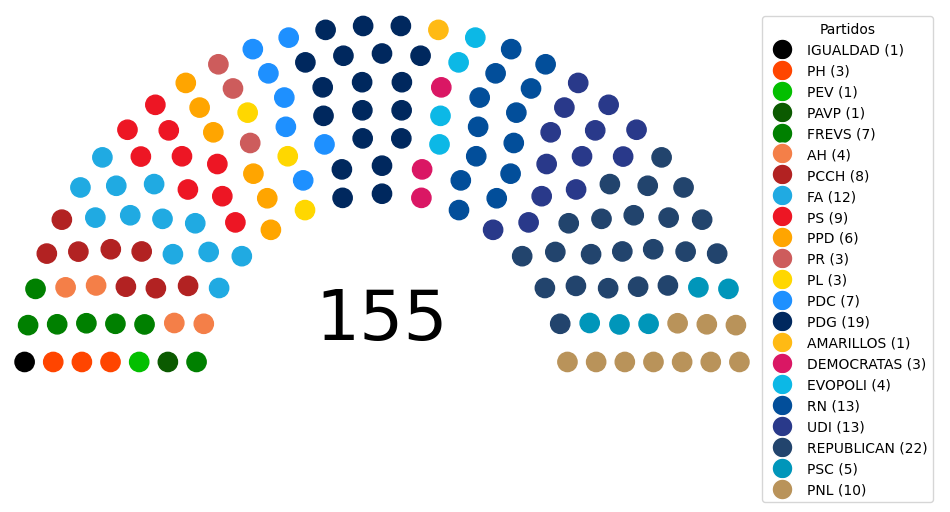

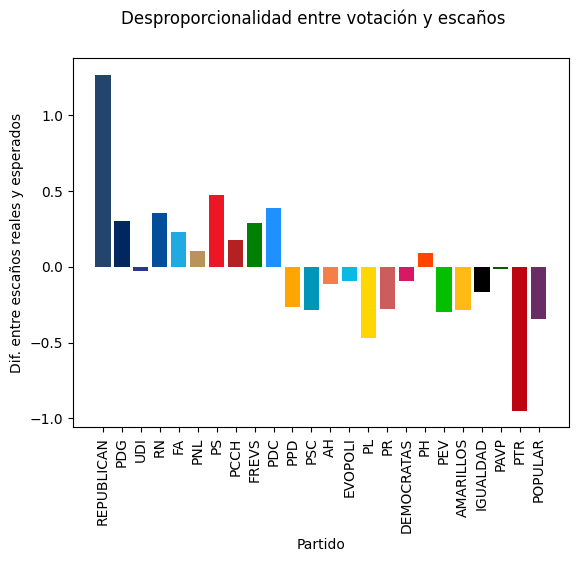

RESUMEN DE ESTADÍSTICAS:
            
Mediana de votación para candidatos electos: 6.92%

Candidatos con menos votos que fueron electos:
                                          Pacto Partido  Distrito  Votos (%)
Candidato                                                                   
PAOLA JOYCE MARTINEZ SANDOVAL              PAVP    PAVP        13   1.151477
ELISA ANDREA ROJAS HERRERA                PH/PI      PH         8   1.223306
NATALIA GARRIDO TORO                      PH/PI      PH        12   1.517346
AMELIA DEL CARMEN GALLEGOS RAMIREZ        PH/PI      PH         9   1.539200
GINO LORENZINI BARRIOS              REP/PNL/PSC     PSC        10   1.813421

Candidatos con más votos que no fueron electos:
                              Pacto Partido  Distrito  Votos (%)
Candidato                                                       
LUIS MALLA VALENZUELA        UNIDAD      PL         1  21.535515
ANDREA MACIAS PALMA          UNIDAD      PS        27  15.441259
RENE ALINCO BUS

In [12]:
results_dhondt_nat = appoint_divisor_national(
    df_no_pact,
    total_seats=155,
    assign_type="dhondt",
    party_threshold=1/155,
    selection_criteria=("votes", False)
)
results_dhondt_nat.loc[:, "pact"] = df["pact"]

app_dhondt_nat = Apportionment(
    results=results_dhondt_nat,
    colors=colors,
    party_order=party_order
)

app_dhondt_nat.summary()

### D'Hondt nacional con umbral alto

Aunque D'Hondt nacional no se usa con umbrales altos en ningún país (a
conocimiento del autor), es la primera idea que a uno se le ocurriría para
resolver el problema de la fragmentación que ocurre en lugares como los Países
Bajos. Se aplicará el mismo umbral de 4% usado para [D'Hondt por distrito con
umbral nacional](#dhondt-con-umbral-nacional).

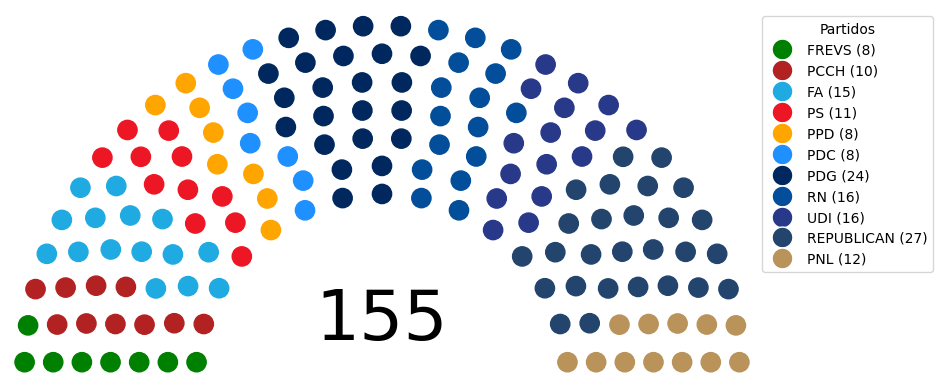

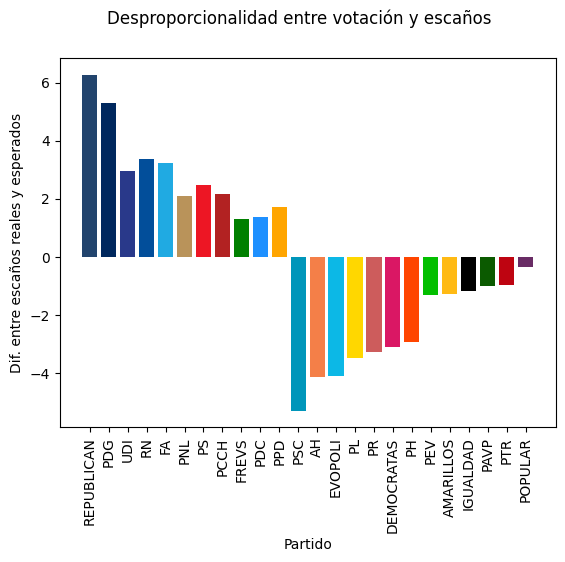

RESUMEN DE ESTADÍSTICAS:
            
Mediana de votación para candidatos electos: 6.63%

Candidatos con menos votos que fueron electos:
                                     Pacto Partido  Distrito  Votos (%)
Candidato                                                              
ALEJANDRO NAVARRO BRAIN           FREVS/AH   FREVS        20   1.896640
KAREN OSORIO MUÑOZ                     PDG     PDG        10   1.902393
CINDY MACIAS TOLEDO                    PDG     PDG        14   1.986976
ITALO OMEGNA VERGARA           REP/PNL/PSC     PNL         8   2.050492
CAMILA FRANCESCA DOÑAS VARGAS          PDG     PDG         6   2.177350

Candidatos con más votos que no fueron electos:
                                       Pacto Partido  Distrito  Votos (%)
Candidato                                                                
SEBASTIAN PATRICIO VIDELA CASTILLO    UNIDAD      PL         3  23.306486
LUIS MALLA VALENZUELA                 UNIDAD      PL         1  21.535515
ANDREA MACIAS 

In [13]:
results_dhondt_nat_threshold = appoint_divisor_national(
    df_no_pact,
    total_seats=155,
    assign_type="dhondt",
    party_threshold=0.04,
    selection_criteria=("votes", False)
)
results_dhondt_nat_threshold.loc[:, "pact"] = df["pact"]

app_dhondt_nat_threshold = Apportionment(
    results=results_dhondt_nat_threshold,
    colors=colors,
    party_order=party_order
)

app_dhondt_nat_threshold.summary()

## Sistemas bipartidistas

Estos sistemas, contrario a los anteriores, no velan por un alto nivel de proporcionalidad (ni distrital ni nacional), cambiándolo por menor fragmentación (lo cual, en teoría, implica mayor gobernabilidad).

Características de los sistemas bipartidistas:
* Tienen un bajo nivel de proporcionalidad, tanto a nivel país como distrito.
* Son muy susceptibles al [voto
  estratégico](https://en.wikipedia.org/wiki/Strategic_voting).
* Tienden a [degenerar a un sistema
  bipartidista](https://en.wikipedia.org/wiki/Duverger%27s_law) dado el
  suficiente tiempo (de ahí proviene el nombre de la categoría).
* Disminuyen la fragmentación política, pues solo permiten que los partidos más
  grandes accedan a escaños en el Congreso.
* En general son muy sencillos de entender.

### Binominal

El sistema binominal es un sistema D'Hondt por distrito (y usando pactos), con
la peculiaridad de que todos los distritos escogen exactamente 2 escaños. Su
uso más conocido fue en las elecciones de la Cámara de Diputados y el Senado
[en Chile](https://en.wikipedia.org/wiki/Binomial_voting_system), entre 1989 y
2013.

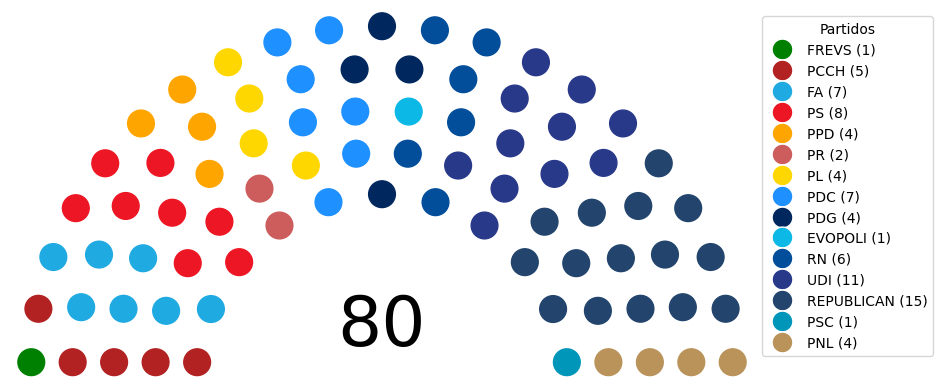

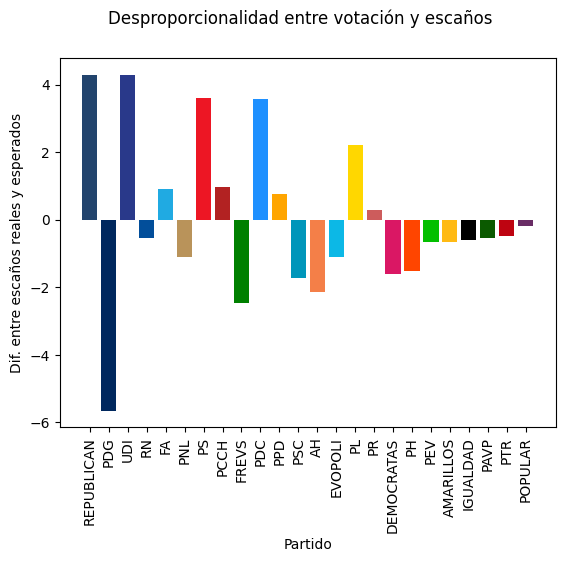

RESUMEN DE ESTADÍSTICAS:
            
Mediana de votación para candidatos electos: 13.37%

Candidatos con menos votos que fueron electos:
                                Pacto Partido Distrito  Votos (%)
Candidato                                                        
RAFAEL VERA CASTILLO           UNIDAD      PR       5b   3.543019
PATRICIO PINILLA VALENCIA      UNIDAD     PDC      21a   5.133165
CARLOS CHANDIA ALARCON     CHILEVAMOS      RN      19a   6.919242
SERGIO BOBADILLA MUÑOZ     CHILEVAMOS     UDI      20a   7.392914
JOSE MONTALVA FEUERHAKE        UNIDAD     PPD      23a   7.910280

Candidatos con más votos que no fueron electos:
                                     Pacto     Partido Distrito  Votos (%)
Candidato                                                                 
ROBERTO CELEDON FERNANDEZ           UNIDAD          FA      17b  18.474403
CATALINA DEL REAL MIHOVILOVIC  REP/PNL/PSC  REPUBLICAN      11b  18.412783
ANA MARIA GAZMURI VIEIRA          FREVS/AH         

In [14]:
results_bin = appoint_divisor_district(
    df_bin,
    district_seats=district_seats_bin,
    assign_type="dhondt",
    party_threshold=0.0
)

app_bin = Apportionment(
    results=results_bin,
    colors=colors,
    party_order=party_order
)

app_bin.summary()

### Uninominal (first-past-the-post)

El sistema uninominal (conocido coloquialmente en inglés como
*first-past-the-post*) es un sistema de mayoría simple, donde solo hay un
escaño por distrito, y el candidato que obtiene más votos se lo queda. Este
modelo es ampliamente usado, incluyendo en la [Cámara de Representantes de los
Estados
Unidos](https://en.wikipedia.org/wiki/United_States_House_of_Representatives),
la [Cámara de los Comunes del Reino
Unido](https://en.wikipedia.org/wiki/House_of_Commons_of_the_United_Kingdom) y
la [Cámara de los Comunes de
Canadá](https://en.wikipedia.org/wiki/House_of_Commons_of_Canada). También se
usa para escoger [alcaldes en
Chile](https://en.wikipedia.org/wiki/Elections_in_Chile#Municipal_elections).

Para efectos de la simulación, como en cada distrito hay varios candidatos por
pacto (contrario a las elecciones de alcalde), una mayoría simple entre todos
los candidatos daría resultados distintos a la realidad. Por ejemplo, dos
candidatos del partido A que obtienen el 20% cada uno serían vencidos por un
candidato del partido B que obtuvo un 25%, aunque en la realidad solo se
lanzaría un candidato del partido A (que obtendría el 40% de los votos y
ganaría). Para mitigar este problema, en vez de escoger al candidato más
votado, se escogerá al **pacto** más votado, luego al partido más votado dentro
de ese pacto, y finalmente al candidato más votado dentro de ese partido
(equivalente a D'Hondt con un solo escaño por distrito).

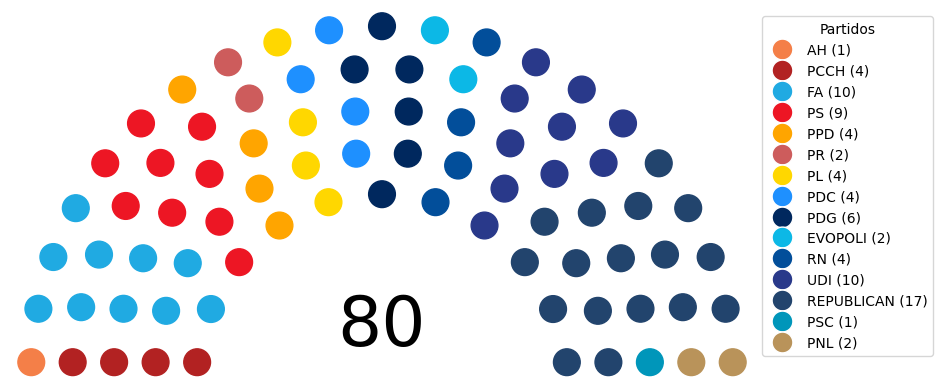

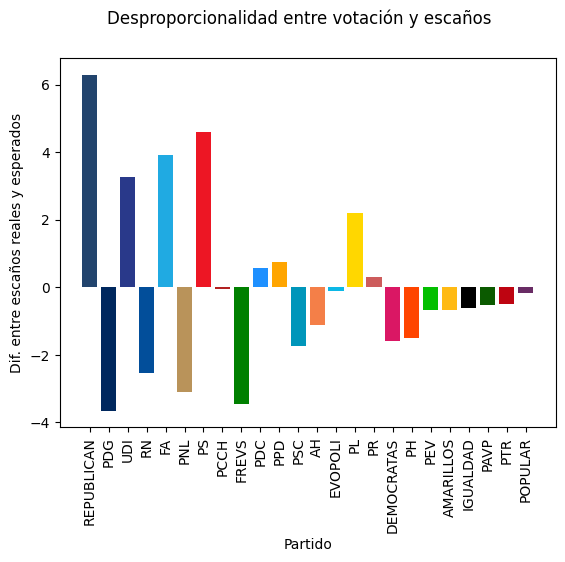

RESUMEN DE ESTADÍSTICAS:
            
Mediana de votación para candidatos electos: 25.32%

Candidatos con menos votos que fueron electos:
                                     Pacto     Partido Distrito  Votos (%)
Candidato                                                                 
MARIA CANDELARIA ACEVEDO SAEZ       UNIDAD        PCCH      20c   9.729948
VERONICA PIZARRO GARCIA        REP/PNL/PSC  REPUBLICAN       5b  10.870310
JUAN SANTANA CASTILLO               UNIDAD          PS       4a  11.219818
CARLOS JOSE CARVAJAL GALLARDO       UNIDAD         PPD       2a  13.888965
ADOLFO MILLABUR ÑANCUIL             UNIDAD          FA      21a  14.808914

Candidatos con más votos que no fueron electos:
                                Pacto     Partido Distrito  Votos (%)
Candidato                                                            
CONSTANZA HUBE PORTUS      CHILEVAMOS         UDI      11d  32.670140
IRACI HASSLER JACOB            UNIDAD        PCCH      10a  31.428975
JUAN IRA

In [15]:
results_mono = appoint_divisor_district(
    df_mono,
    district_seats=district_seats_mono,
    assign_type="dhondt",
    party_threshold=0.0
)

app_mono = Apportionment(
    results=results_mono,
    colors=colors,
    party_order=party_order
)

app_mono.summary()

## Sistema biproporcional

El sistema biproporcional se creó como una alternativa para asegurar
representación en dos niveles: la cantidad de escaños por partido es
proporcional a su votación nacional, y la cantidad de escaños por distrito es
proporcional a su población. Esto se logra asignando *divisores* a cada partido
y distrito, donde la cantidad de escaños de un partido en un distrito es
equivalente a los votos que obtuvo dividido en **ambos** divisores.
Inicialmente los divisores son 1 para cada partido, y la cantidad de votantes
por escaño para cada distrito; luego, los divisores son ajustados levemente
para asegurar una asignación apropiada.

Este sistema es utilizado para elecciones locales en algunos cantones de Suiza,
siendo usado por primera vez en el [Consejo Cantonal de
Zúrich](https://en.wikipedia.org/wiki/Cantonal_Council_of_Zurich) en 2006.

Se decidió simular el sistema biproporcional asignando escaños a los partidos
con el método de Sainte-Laguë (usado en Suiza), con un umbral electoral
nacional equivalente a un escaño; de esta manera se pueden comparar los
resultados obtenidos con [D'Hondt nacional con umbral
bajo](#dhondt-nacional-con-umbral-bajo).

**Observación:** como, en esta simulación, no todos los partidos tienen tantos
candidatos como escaños disponibles en cada distrito, es posible que un partido
sea asignado más escaños en un distrito que el número de candidatos que
presentó. Por simplicidad, se decidió dejar ese escaño vacío para efectos de la
simulación.

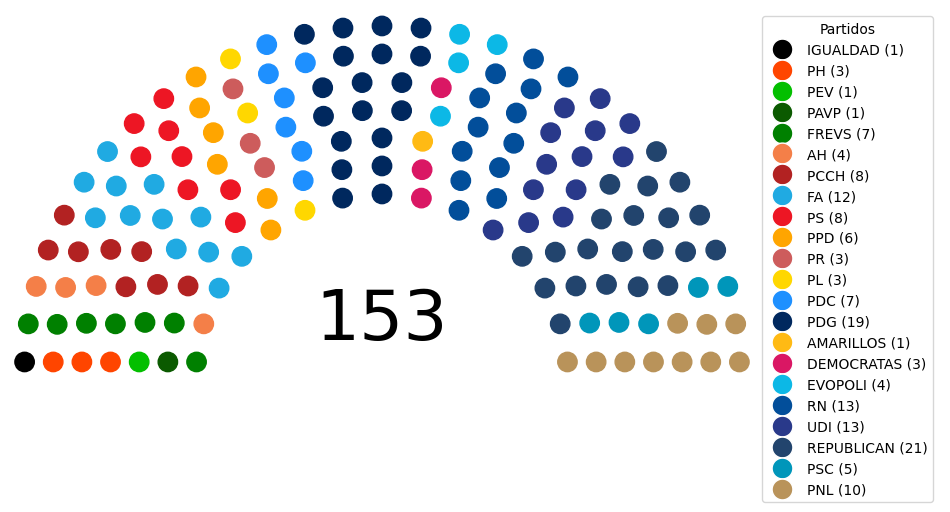

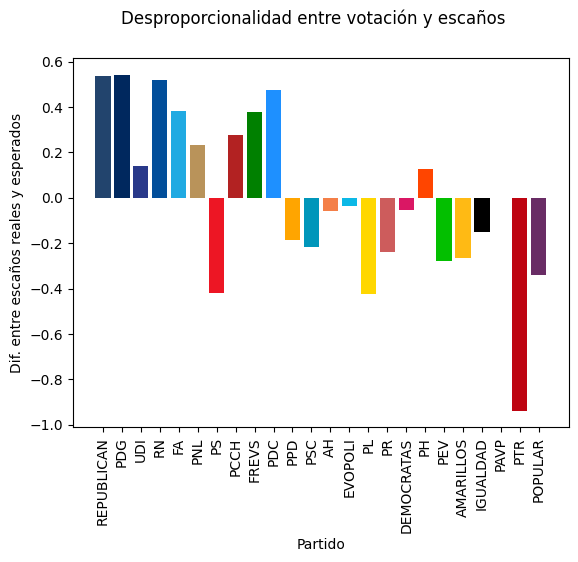

RESUMEN DE ESTADÍSTICAS:
            
Mediana de votación para candidatos electos: 7.43%

Candidatos con menos votos que fueron electos:
                                    Pacto   Partido  Distrito  Votos (%)
Candidato                                                               
XUXA ALVAREZ FERNANDEZ               PAVP      PAVP         9   0.719847
ELISA ANDREA ROJAS HERRERA          PH/PI        PH         8   1.223306
NATALIA GARRIDO TORO                PH/PI        PH        12   1.517346
AMELIA DEL CARMEN GALLEGOS RAMIREZ  PH/PI        PH         9   1.539200
JAVIER SANDOVAL OJEDA               PH/PI  IGUALDAD        20   1.615228

Candidatos con más votos que no fueron electos:
                                    Pacto     Partido  Distrito  Votos (%)
Candidato                                                                 
XIMENA NARANJO PINTO           CHILEVAMOS         UDI         2  10.568977
ALEJANDRA VALDEBENITO TORRES   CHILEVAMOS         UDI        27  10.349253
MAR

In [16]:
results_biprop = appoint_biproportional(
    df_no_pact,
    district_seats=district_seats,
    assign_type="sainte-lague",
    party_threshold=1/155
)
results_biprop["pact"] = df["pact"]

app_biprop = Apportionment(
    results=results_biprop,
    colors=colors,
    party_order=party_order
)

app_biprop.summary()

## Sistemas mixtos

Otra forma de balancear representatividad distrital y nacional son los **sistemas mixtos**. Estos tienen dos fases: la primera asigna escaños a cada distrito (asegurando que todos tengan un mínimo de representación), mientras que la segunda asigna escaños a nivel nacional (compensando las posibles desigualdades generadas en la primera etapa). Se puede ver como una mezcla entre un sistema por distrito (ya sea proporcional o no) y un sistema proporcional nacional.

Características de sistemas mixtos:
- Logran una mayor representatividad a nivel nacional que los sistemas proporcionales por distrito, aunque son peores que los sistemas proporcionales nacionales.
- Inversamente, logran una peor representatividad a nivel distrital que los sistemas proporcionales por distrito, pero aseguran representación para todos los distritos (contrario a los sistemas proporcionales nacionales).
- Son más sencillos de entender que el sistema biproporcional.
- Son susceptibles a votación estratégica y manipulación electoral (especialmente cuando hay partidos que aseguran los suficientes escaños distritales como para no poder acceder a ningún escaño compensatorio).

### Mixed-Member Proportional / Additional-Member System

La representación proporcional mixta (Mixed-member proportional, MMP) es un
sistema mixto donde en la primera fase, cada distrito elige a un solo candidato
(el que obtenga más votos); luego, se asignan escaños compensatorios a nivel
nacional para asegurar proporcionalidad. Si la proporcionalidad absoluta no se
puede obtener debido a que un partido ganó demasiados escaños distritales,
existen varias maneras de abordar el problema:
- Agregar escaños extra (*overhang seats*), que son entregados a los partidos
  que ganaron demasiados escaños distritales; este es el sistema usado en la
  [Cámara de Representantes de Nueva
  Zelanda](https://en.wikipedia.org/wiki/New_Zealand_House_of_Representatives).
  Causa que el tamaño del parlamento sea variable, pero generalmente agrega
  pocos escaños.
- Agregar escaños extra, que son entregados a los partidos que **no ganaron**
  demasiados escaños distritales hasta que se se alcance la proporcionalidad;
  este es el sistema que fue usado hasta las elecciones de 2021 en el
  [Bundestag de Alemania](https://en.wikipedia.org/wiki/Bundestag). Asegura
  proporcionalidad, pero puede inflar muchísimo el tamaño del parlamento (en el
  caso de las últimas elecciones alemanas, pasó [de 598 a
  735](https://en.wikipedia.org/wiki/2021_German_federal_election)).
- Eliminar los escaños distritales en exceso, reemplazándolos por escaños a
  nivel nacional; este es el sistema que será usado a partir de 2025 en el
  Bundestag de Alemania. Mantiene constante el tamaño del parlamento, pero
  causa que algunos distritos pierdan su derecho a un representante.
- Asignar los escaños compensatorios que se puedan, manteniendo todos los
  escaños distritales; este sistema, también conocido como **Additional-member
  system** (AMS), es usado en la [Cámara de Diputados de
  Bolivia](https://en.wikipedia.org/wiki/Chamber_of_Deputies_(Bolivia)) y el
  [Parlamento Escocés](https://en.wikipedia.org/wiki/Scottish_Parliament).
  Mantiene constante el tamaño del parlamento y asegura que todos los distritos
  tengan representación, pero no asegura proporcionalidad.

Para efectos de esta simulación, se decidió utilizar **AMS**, manteniendo un
parlamento de 120 diputados. 80 de los diputados son electos en distritos
usando el [sistema uninominal](#uninominal-first-past-the-post), y 40 son
asignados usando [D'Hondt a nivel nacional](#dhondt-nacional-con-umbral-alto),
con un umbral del 4%. Los escaños niveladores de cada partido fueron asignados
a sus candidatos con más votos (que no hayan sido electos en su distrito); esto
se conoce como [*Zweitmandat*](https://en.wikipedia.org/wiki/Zweitmandat), y
fue usado en el [Landtag de
Baden-Württemberg](https://en.wikipedia.org/wiki/Landtag_of_Baden-W%C3%BCrttemberg)
hasta el año 2022. 

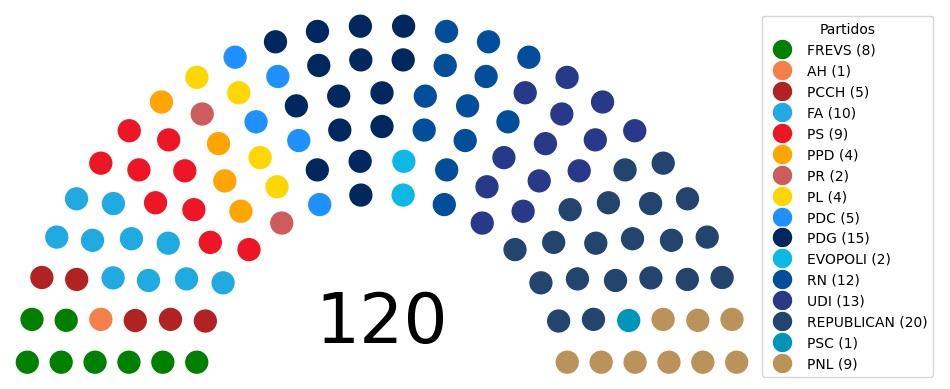

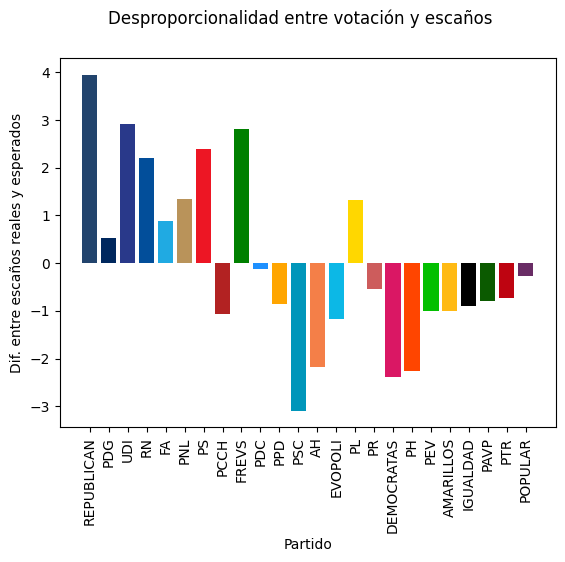

RESUMEN DE ESTADÍSTICAS:
            
Mediana de votación para candidatos electos: 22.63%

Candidatos con menos votos que fueron electos:
                                   Pacto Partido Distrito  Votos (%)
Candidato                                                           
HERNAN VELASQUEZ NUÑEZ          FREVS/AH   FREVS       3a   5.734557
BERNARDO ORLANDO ULLOA PEREIRA       PDG     PDG      20b   6.341887
MARCELO CARRASCO CARRASCO       FREVS/AH   FREVS      23c   7.006726
ZANDRA PARISI FERNANDEZ              PDG     PDG      12e   7.326847
PAOLA DEBIA GONZALEZ                 PDG     PDG       3a   8.001633

Candidatos con más votos que no fueron electos:
                                  Pacto     Partido Distrito  Votos (%)
Candidato                                                              
ANA MARIA GAZMURI VIEIRA       FREVS/AH          AH      12c  27.848320
TATIANA URRUTIA HERRERA          UNIDAD          FA       8a  26.224576
MARCOS BARRAZA GOMEZ             UNIDAD   

In [17]:
results_ams = appoint_divisor_mixed(
    df_mono,
    fixed_district_seats=district_seats_mono,
    top_up_seats=40,
    district_type="dhondt",
    national_type="dhondt",
    district_party_threshold=0.00,
    national_party_threshold=0.04,
    district_selection_criteria=("votes", False),
    national_selection_criteria=("votes", False)
)

app_ams = Apportionment(
    results=results_ams,
    colors=colors,
    party_order=party_order
)

app_ams.summary()

### D'Hondt con escaños niveladores

Una alternativa a MMP/AMS es que la primera fase no tenga un candidato electo
por distrito, sino que se elijan varios candidatos usando un **sistema
proporcional** (en este caso D'Hondt). De esta forma la primera fase tiene una
mejor proporcionalidad, permitiendo que la segunda fase (entregar escaños
niveladores nacionales) tenga que hacer modificaciones más leves. Este sistema
es usado para escoger los parlamentos de cuatro de los cinco países nórdicos:
el [Folketing de Dinamarca](https://en.wikipedia.org/wiki/Folketing), el
[Alþingi de Islandia](https://en.wikipedia.org/wiki/Althing), el [Riksdag de
Suecia](https://en.wikipedia.org/wiki/Riksdag) y el [Storting de
Noruega](https://en.wikipedia.org/wiki/Storting) (estos dos últimos con el
método de Sainte-Laguë en vez de D'Hondt). Para los curiosos, el [Parlamento de
Finlandia](https://en.wikipedia.org/wiki/Parliament_of_Finland) (el quinto país
nórdico) usa [D'Hondt por distrito](#dhondt-estándar).

En esta simulación, se agregaron 25 escaños niveladores (con un umbral nacional
del 4%) al parlamento de 155 diputados (sin umbral), para obtener un total de
180 escaños. Al igual que con
[MMP/AMS](#mixed-member-proportional--additional-member-system), se usó el
sistema de *Zweitmandat* (escogiendo los perdedores más votados) para asignar
los escaños niveladores al interior de los partidos.

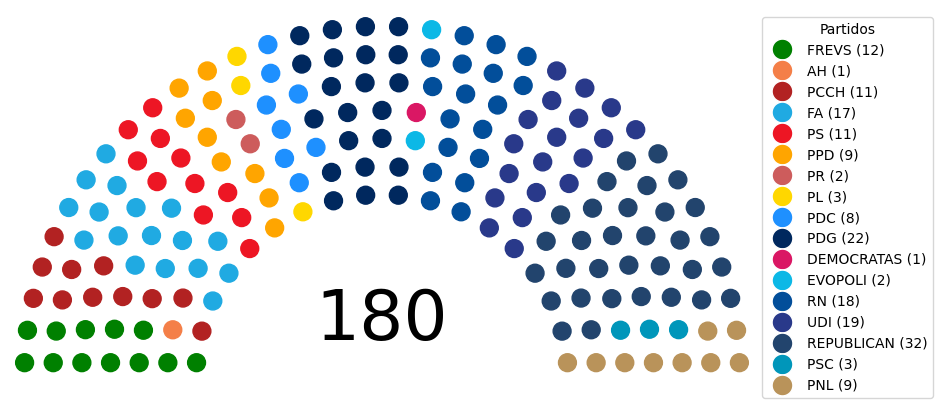

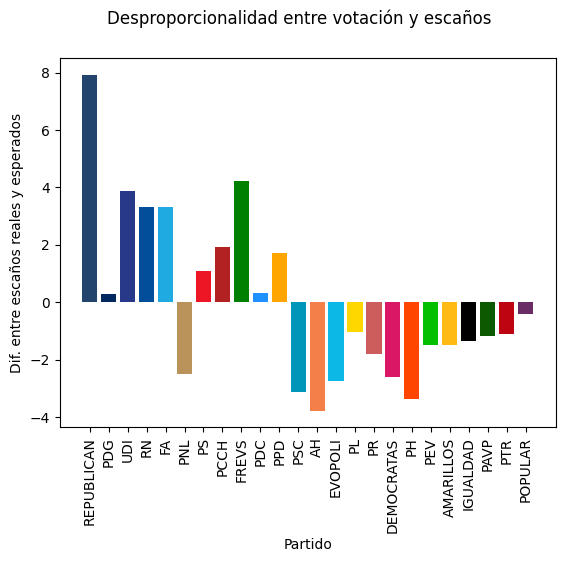

RESUMEN DE ESTADÍSTICAS:
            
Mediana de votación para candidatos electos: 7.13%

Candidatos con menos votos que fueron electos:
                                 Pacto Partido  Distrito  Votos (%)
Candidato                                                          
BERNARDO SALINAS MAYA           UNIDAD    PCCH         5   0.851361
LORENA FRIES MONLEON            UNIDAD      FA        10   0.881533
FERNANDO ZAMORANO PERALTA       UNIDAD     PPD        15   1.339114
ROBERTO ARROYO MUÑOZ       REP/PNL/PSC     PSC        20   1.344376
ALEJANDRO NAVARRO BRAIN       FREVS/AH   FREVS        20   1.896640

Candidatos con más votos que no fueron electos:
                                      Pacto     Partido  Distrito  Votos (%)
Candidato                                                                   
LUPERCIANO MUÑOZ GONZALEZ            UNIDAD          PR        27  12.730015
MARCIA RAPHAEL MORA              CHILEVAMOS          RN        27  10.204867
RAMON GALLEGUILLOS CASTILLO   

In [18]:
results_dhondt_level = appoint_divisor_mixed(
    df,
    fixed_district_seats=district_seats,
    top_up_seats=25,
    district_type="dhondt",
    national_type="dhondt",
    district_party_threshold=0.00,
    national_party_threshold=0.04,
    district_selection_criteria=("votes", False),
    national_selection_criteria=("votes", False)
)

app_dhondt_level = Apportionment(
    results=results_dhondt_level,
    colors=colors,
    party_order=party_order
)

app_dhondt_level.summary()

## Propuesta de sistema electoral

Teniendo en cuenta las características de todos los sistemas vistos
anteriormente, se propone un sistema que cumple las siguientes características:

- Obtiene una representación aceptable a nivel distrital.
- Obtiene un buen nivel de proporcionalidad a nivel nacional.
- Impide la fragmentación excesiva, limitando la proliferación de partidos
  pequeños (pero permitiendo su existencia si tienen mucho apoyo en un
  distrito, o un nivel suficiente de apoyo a nivel nacional).
- Permite un parlamento más pequeño.
- Es relativamente sencillo de entender (al menos a nivel intuitivo) y de
  verificar los resultados.
- Es capaz de generar un "ranking" entre diputados electos, lo cual es útil
  para asegurar paridad de género (se cambian los diputados con menor ranking
  por otro candidato del mismo partido y distrito, pero del género opuesto).

El sistema está altamente inspirado en el [Riksdag de
Suecia](https://en.wikipedia.org/wiki/Riksdag), con unas pequeñas
modificaciones. Los pasos son los siguientes:

1. Establecer distritos más grandes que los actuales, con entre 3 y 10
   diputados electos en cada uno.
1. En cada distrito, elegir a los diputados mediante un sistema proporcional
   **sin pactos**. De esta manera, los partidos más pequeños no pueden
   "alimentarse" de los votos de partidos más grandes dentro de su pacto.
1. Los partidos que tienen un porcentaje de votación nacional por sobre cierto
   **umbral nacional** pueden acceder a escaños en todos los distritos. Los
   partidos que estén por debajo del umbral nacional, pero estén por sobre un
   **umbral distrital** en algún distrito, pueden acceder a escaños en ese
   distrito. Esto último permite que los partidos más pequeños puedan obtener
   algo de representación, si concentran el suficiente apoyo en un distrito. Un
   independiente también puede acceder al parlamento si supera el umbral
   distrital (y tiene los suficientes votos para ser electo).
1. Para asegurar una mejor representatividad a nivel nacional, asignar una
   cierta cantidad de **escaños niveladores** a los partidos sub-representados
   en el parlamento.
1. Para cada partido, distribuir sus escaños niveladores entre los distritos
   con un sistema proporcional, usando los votos que obtuvo el partido en cada
   distrito y la cantidad de escaños que ya tiene asignado en cada distrito.
   Esta forma de asignación tiene una inclinación hacia distritos con más
   votantes por escaño, lo cual es positivo pues permite nivelar esa
   desigualdad un poco.

Se puede hacer un "ranking" entre los diputados electos de la siguiente manera:
  * Primero van los diputados que fueron electos directamente en su distrito.
    Son ordenados según el **coeficiente** con el cual fueron electos,
    calculado usando porcentajes de votación en el distrito (para que así los
    distritos con más votantes no sean más importantes).
  * Luego van los diputados electos mediante escaños niveladores, que son
    ordenados de la misma manera que fueron asignados. Por ejemplo, si primero
    se le dio un escaño al PS (asginado al distrito 4) y luego a RN (asignado
    al distrito 9), entonces el diputado PS del distrito 4 estaría una posición
    antes que el diputado RN del distrito 9.

Al ser un sistema que busca proporcionalidad a nivel de partidos, permite el
arrastre (si no lo hiciera, los votos hacia un candidato muy popular se
"perderían" y no se obtendría representatividad). Las listas cerradas
solucionan el problema, pues se vota directamente por el partido; sin embargo,
no sirven para legitimar el proceso, pues no existe ningún criterio democrático
para determinar la posición de un candidato sobre otro en la lista del partido.
Una forma de mitigar (mas no solucionar) la percepción de la población sería
usar papeletas similares a las [nuevas papeletas de Países
Bajos](https://nltimes.nl/2024/03/11/five-dutch-municipalities-experiment-small-ballot-european-elections),
donde primero se marca un partido y luego el número del candidato. Esto no solo
hace que las papeletas sean de un tamaño razonable, sino que hacer notar a las
personas que no están votando por una persona, sino que por un partido
primeramente.

### Parámetros a utilizar

Habiendo definido el sistema a nivel general, es necesario discutir los
parámetros específicos que podrían servir en el caso chileno.

* **Distritos:** se propone un distrito por región, con un mínimo de 3 diputados
por distrito (para que exista algo de proporcionalidad a nivel distrital). La
Región Metropolitana se dividirá en 4 distritos, pues de lo contrario se
tendría un único distrito escogiendo a un tercio de los diputados.

   La división de la Región Metropolitana es la siguiente:
   * RM1: Distrito 8 (435.344 votantes)
   * RM2: Distritos 9 y 11 (746.865 votantes)
   * RM3: Distritos 10 y 13 (696.511 votantes)
   * RM4: Distritos 12 y 14 (717.984 votantes)

   Se podría hacer una división a nivel de comunas si se busca una mayor
   igualdad de población entre zonas, pero para efectos de la simulación no se
   pueden subdividir los distritos electorales usados en 2021 (ya que comparten
   candidatos).

   La asignación de escaños para los distintos distritos se realizará con
   D'Hondt; de esta manera se prioriza dar más escaños a los distritos más
   grandes, contrarrestando un poco la asignación de 3 escaños a cada distrito
   sin importar su población.

* **Número de diputados**: se decidió crear un parlamento con 100 diputados
  electos en los distritos y 20 diputados electos mediante escaños niveladores,
  para obtener un total de **120 diputados**; este es el número que había antes
  de la reforma electoral (cuando los diputados eran electos usando el sistema
  binominal). Con 20 escaños niveladores, estos ocupan un 16.7% de los escaños
  totales; este valor está en línea con los porcentajes vistos en otras
  legislaturas que usan sistemas proporcionales con escaños niveladores (desde
  un 11.1% en Suecia hasta un 22.3% en Dinamarca). La cantidad de escaños
  niveladores debe ser suficiente como para garantizar proporcionalidad entre
  los partidos principales, pero no demasiados como para sobrerrepresentar
  excesivamente a los mismos (versus los partidos más pequeños, que no acceden
  a escaños niveladores).

* **Método de asignación**: existen tres sistemas proporcionales que se pueden
  utilizar en la asignación de escaños por distrito. En cada uno se calcula un
  coeficiente para cada partido, en base a la cantidad de votos que ha recibido
  $V$ y la cantidad de escaños que ya le han sido asignados $s$; el partido con
  el coeficiente más alto recibe el siguiente escaño.
  1. [**D'Hondt**](https://en.wikipedia.org/wiki/D%27Hondt_method): es el
     sistema actualmente usado en Chile, y es el más sencillo de entender. El
     coeficiente de cada partido es $V/(s+1)$. Tiende a sobrerrepresentar a los
     partidos más grandes, especialmente en distritos con pocos electores o
     muchos partidos (en el caso chileno se tienen ambos).
  2. [**Sainte-Laguë**](https://en.wikipedia.org/wiki/Sainte-Lagu%C3%AB_method):
     el coeficiente de cada partido es $V/2(s+1)$. Es un poco más complicado de
     explicar (el factor 2 que se agrega no tiene una razón sencilla), pero no
     sobrerrepresenta a los partidos más grandes. Con pocos electores por
     distrito, puede sobrerrepresentar a partidos que obtienen una votación
     baja pero consistente a lo largo del país (ya que siempre obtienen un
     escaño por distrito, pero nunca más de uno). Esto ocurre, por ejemplo, con
     el PDG, que obtendría 6 escaños más de los que merece según su proporción
     de voto.
  3. [**Sainte-Laguë
     modificado**](https://en.wikipedia.org/wiki/Sainte-Lagu%C3%AB_method#Modified_Sainte-Lagu%C3%AB_method):
     el coeficiente de cada partido es $V/2(s+1)$ si $s > 0$, y $V/C$ en el
     caso contrario, con $C > 1$. Esto sirve para que sea más difícil que un
     partido obtenga su primer escaño, evitando el problema antes mencionado
     con Sainte-Laguë estándar. Tiende a sobrerrepresentar a partidos más
     grandes, pero en mucha menor medida que D'Hondt. Este es el sistema usado
     en Suecia (con $C=1.2$) y Noruega (con $C=1.4$).
  
  En vista de lo anterior, se decidió usar Sainte-Laguë modificado con $C =
  1.2$, ya que el coeficiente $C=1.4$ sobrerrepresentaba excesivamente a los
  partidos más grandes. La asignación de escaños niveladores se hace con
  Sainte-Laguë estándar (ya que el objetivo es precisamente obtener el
  resultado más proporcional posible), al igual que la asignación de escaños
  niveladores entre los distritos.

* **Umbrales**: quizás el tema más crítico del sistema es la elección de los
  umbrales (nacional y distrital), pues esto determina cuáles partidos logran
  escaños en el Congreso y cuáles no. El umbral más comúnmente mencionado en
  las discusiones sobre la reforma política chilena es de un 5% nacional, lo
  cual dejaría solo unos pocos partidos con representación (incluso
  considerando la fusión del Frente Amplio, algo que esta simulación no toma en
  cuenta). Una manera de permitir un mínimo de representación para los partidos
  que estén debajo del umbral nacional, pero que tengan fuerza en regiones
  particulares, es imponer un umbral distrital mucho mayor al nacional. En
  Suecia el umbral distrital es de un 12%, el triple del umbral nacional del
  4%. Si se busca reducir la fragmentación (a costa de los partidos más
  pequeños), se puede utilizar un umbral distrital de un 15% junto con el
  umbral nacional del 5%.
  
  Para efectos de esta simulación, se usarán umbrales nacional y distrital del
  4% y 12%, respectivamente. Los umbrales mayores generaban parlamentos con
  desproporcionalidad altísima, aunque quizás podrían funcionar en la
  práctica, considerando que los partidos más pequeños probablemente se
  fusionen para obtener mejores resultados.

### Generación de nuevos distritos

In [19]:
# diccionario que asocia a cada distrito antiguo con su distrito nuevo
new_district_mapper = {
    "district": {
        1: "AP",
        2: "TA",
        3: "AN",
        4: "AT",
        5: "CO",
        6: "VA",
        7: "VA",
        8: "RM1",
        9: "RM2",
        10: "RM3",
        11: "RM2",
        12: "RM4",
        13: "RM3",
        14: "RM4",
        15: "LI",
        16: "LI",
        17: "ML",
        18: "ML",
        19: "NB",
        20: "BI",
        21: "BI",
        22: "AR",
        23: "AR",
        24: "LR",
        25: "LL",
        26: "LL",
        27: "AI",
        28: "MA"
    }
}

In [20]:
# asignar distritos nuevos y recalcular porcentajes de votación
df_new_districts = df.replace(to_replace=new_district_mapper)
df_new_districts = add_percentage(df_new_districts)

# calcular votos por distrito
new_district_votes = df_new_districts.groupby("district")["votes"].sum()

# escaños minimos a cada distrito
initial_seats = pd.Series(
    [3]*len(new_district_votes),
    index=new_district_votes.index
)

# asignar escaños faltantes
new_district_seats = assign_seats_to_parties(
    new_district_votes,
    100,
    initial_seats,
    lambda x: x+1  # d'hondt
)

### Simulación final

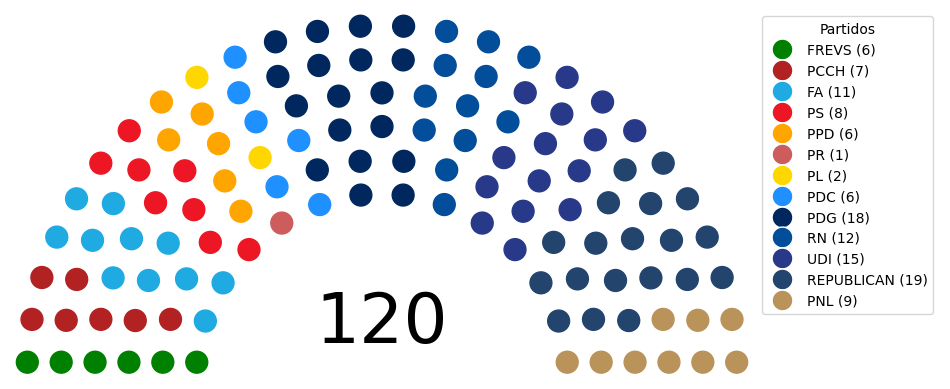

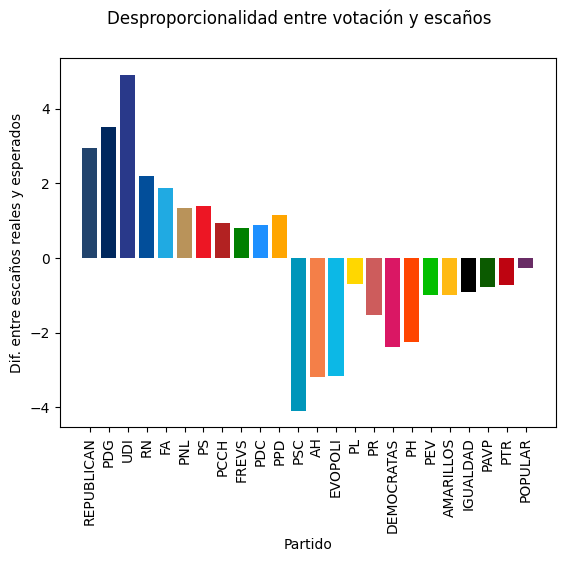

RESUMEN DE ESTADÍSTICAS:
            
Mediana de votación para candidatos electos: 4.31%

Candidatos con menos votos que fueron electos:
                                      Pacto Partido Distrito  Votos (%)
Candidato                                                              
CRISTIAN ARTURO SEGUEL OLIVOS           PDG     PDG      RM3   1.406045
JOSE VALLEJO KNOCKAERT          REP/PNL/PSC     PNL       VA   1.477699
BERNARDO ORLANDO ULLOA PEREIRA          PDG     PDG       BI   1.515764
EDUARDO DURAN SALINAS            CHILEVAMOS      RN      RM3   1.723495
FLOR ROSSANY CONTRERAS VIVALLO          PDG     PDG       AR   1.727479

Candidatos con más votos que no fueron electos:
                                   Pacto Partido Distrito  Votos (%)
Candidato                                                           
VERONICA AGUILAR MARTINEZ         UNIDAD      PR       MA  11.825901
MATIAS FERNANDEZ HARTWIG          UNIDAD      FA       LR  11.344785
CRISTIAN TAPIA RAMOS              

In [21]:
# sainte-lague modificado para asignación a nivel de distrito
def modified_sainte_lague(x):
    return (x==0)*1.2 + (x!=0)*(2*x+1)

results = appoint_swedish(
    df_new_districts,
    new_district_seats,
    20,
    modified_sainte_lague,
    "sainte-lague",
    "sainte-lague",
    0.12,
    0.04
)
app = Apportionment(results, colors, party_order)
app.summary()